In [1]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
    print("Not running in Google Colab.")

Not running in Google Colab.


In [2]:
import matplotlib.pyplot as plt

import numpy as np

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDataset, AgentDataset, OfflineEgoDataset

from l5kit.rasterization import build_rasterizer
from l5kit.configs import load_config_data
from l5kit.visualization import draw_trajectory, TARGET_POINTS_COLOR
from l5kit.geometry import transform_points
from tqdm import tqdm
from collections import Counter
from l5kit.data import PERCEPTION_LABELS
from prettytable import PrettyTable

import os

from l5kit.visualization.visualizer.zarr_utils import zarr_to_visualizer_scene
from l5kit.visualization.visualizer.visualizer import visualize
from bokeh.io import output_notebook, show
from l5kit.data import MapAPI

In [3]:
import os
from collections import Counter
from typing import Dict, Optional

import numpy as np
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.geometry import rotation33_as_yaw

# get config
cfg = load_config_data("../nmp/goal-config-debug.yaml")
print(cfg)
cfg["debug"] = True

{'format_version': 4, 'debug': False, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 4, 'future_num_frames': 12, 'step_time': 0.1, 'render_ego_history': True}, 'raster_params': {'raster_size': [112, 112], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train_full.zarr', 'batch_size': 64, 'shuffle': True, 'num_workers': 2, 'perturb_probability': 0.1}, 'val_data_loader': {'key': 'scenes/validate.zarr', 'batch_size': 64, 'shuffle': False, 'num_workers': 2}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'epochs': 1, 'eval_every_n_steps': 10000}}


In [4]:
dm = LocalDataManager()

rasterizer = build_rasterizer(cfg, dm)

preprocessed_dir = "/mnt/scratch/v_liuhaolan/preprocessed_goal"

from l5kit.dataset import CachedEgoDataset

train_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()
train_dataset = CachedEgoDataset(cfg, train_zarr, rasterizer, preprocessed_path=preprocessed_dir)


Debug: Read preprocessed dataset into memory...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 2336.38it/s]


In [10]:
import torch
import torch.utils.data
import torchvision

import tqdm


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in tqdm.tqdm(self.indices):
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        
        print(label_to_count)
        
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
#        return dataset.train_labels[idx].item()
        yaw = dataset[idx]["target_yaws"][-1]
        if yaw > 0.4:
            return 0
        elif yaw < -0.4:
            return 1
        else:
            return 2

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [65]:
a = ImbalancedDatasetSampler(train_dataset)

print(a.weights)
#sample_1 = torch.multinomial(weights, n_small, replacement=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:03<00:00, 324.18it/s]


{2: 978, 0: 22, 1: 24}
tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
       dtype=torch.float64)


In [69]:
weights = torch.rand(2600000)
q = [i for i in torch.multinomial(weights, 64, replacement=True)]

In [73]:
#from torch.sampler import ImbalancedDatasetSampler

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    sampler=ImbalancedDatasetSampler(train_dataset),
    batch_size=64,
#    num_workers=2           # using multiworkers cause serious hanging problems!
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:03<00:00, 323.92it/s]


{2: 978, 0: 22, 1: 24}


In [74]:
# let's get a batch and evaluate the result
from time import time
s = time()
sample_data_batch = next(iter(train_loader))
print(time()-s)

def get_label(yaw):
    if yaw > 0.4:
        return 0
    elif yaw < -0.4:
        return 1
    else:
        return 2
data = [0]*3
for i in range(64):
    yaw = sample_data_batch["target_yaws"][i][-1]
    data[get_label(yaw)] += 1
    
print(data)

0.286149263381958
[20, 23, 21]


torch.Size([13, 112, 112])


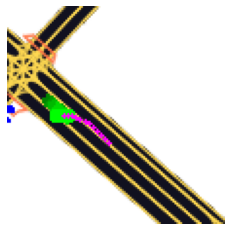

In [34]:
data_ego = sample_data_batch

#print(data_ego)

idx = 13
print(data_ego["image"][idx].shape)

device = ("cuda:0")
data_ego_cuda = {k: v.to(device) for k, v in data_ego.items()}

im_ego = rasterizer.to_rgb((data_ego["image"][idx]).numpy().transpose(1, 2, 0))
target_positions = transform_points(data_ego["target_positions"][idx].numpy(), data_ego["raster_from_agent"][0].numpy())

# weird hack
im_ego = np.ascontiguousarray(im_ego, dtype=np.uint8)

draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
#target_positions = transform_points(traj['positions'].cpu().numpy(), data_ego["raster_from_agent"][0].numpy())

#draw_trajectory(im_ego, (target_positions).astype(np.uint8), TARGET_POINTS_COLOR)

#target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])

plt.imshow(im_ego)
plt.axis('off')
plt.show()


In [ ]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=13,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

In [47]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)  # deprecated

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
from torch import nn
model.conv1 = nn.Conv2d(
    in_channels=13,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


model.avgpool = Identity()
model.fc = Identity()

input_tensor = torch.rand((64,13,112,112))

res = model(input_tensor)

In [44]:
print(res.shape)

torch.Size([64, 32768])


In [58]:
x = torch.rand((64,13,112,112))

model.conv1 = nn.Conv2d(
    in_channels=13,
    out_channels=64,
    kernel_size=(7, 7),
    stride=(2, 2),
    padding=(3, 3),
    bias=False,
)

x=(model.conv1)(x)
x=(model.bn1)(x)
x=(model.relu)(x)
x=(model.maxpool)(x)
x=model.layer1(x)
x=model.layer2(x)
#x=model.layer3(x)  #(7,7)
#x=model.layer4(x) #(4,4)

In [59]:
print(x.shape)

torch.Size([64, 512, 14, 14])
